## 1. Import packages

In [0]:
import os
from urllib.request import urlretrieve
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision.models import vgg16
import torchvision.transforms as T

## 2. Define some useful functions

In [0]:
def download(url, filename=None):
    if filename is None:
        filename = url.split('/')[-1]
    if not os.path.exists(filename):
        print('Downloading {} from {}...'.format(filename, url))
        urlretrieve(url, filename=filename)

def imshow(img, mean, std):
    z = img.cpu() * torch.tensor(std).view(3, 1, 1)
    z = z + torch.tensor(mean).view(3, 1, 1)

    pimg = T.ToPILImage(mode='RGB')(z)

    plt.imshow(np.asarray(pimg))


loss_fn = torch.nn.CrossEntropyLoss()


## 3. Get input image



In [0]:
download('https://github.com/Harry24k/FGSM-pytorch/raw/master/data/giant_panda/1.jpg', filename='giant_panda.jpg')
imsize = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms = T.Compose([
        T.Resize(imsize),
        T.CenterCrop(imsize),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])

img = Image.open('giant_panda.jpg')
img = transforms(img)
img = img.cuda()

## 4. Get pretrained model
 

In [0]:
model = vgg16(pretrained=True)
model = model.cuda()
model = model.eval()
download('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

## 5. Let's classify our image with the pretrained model first!

predicted label before FGSM: giant_panda with confidence of 0.98


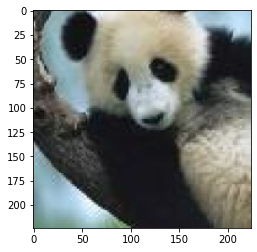

In [5]:
outputs = model.forward(img.unsqueeze(0))
outputs = torch.softmax(outputs, 1)
confidence, y_pred = torch.max(outputs.data, 1)
print('predicted label before FGSM: %s with confidence of %.2f'%(idx2label[y_pred], confidence.item()))
imshow(img, mean, std)

## 6. Apply FGSM to our image

In [0]:
# Apply FGSM to our image
def FGSM(img, label, model, loss_fn, epsilon=0.007):
    model = model.eval()
    img = img.requires_grad_()

    outputs = model.forward(img.unsqueeze(0))
    loss = loss_fn(outputs, label.unsqueeze(0))
    
    loss.backward()

    img.data.copy_(img.data + epsilon * torch.sign(img.grad))

    return img

img = FGSM(img, y_pred.squeeze(), model, loss_fn)






## 7. Let's classify our image again and see if the prediction fails

predicted label after FGSM: indri with confidence of 0.31


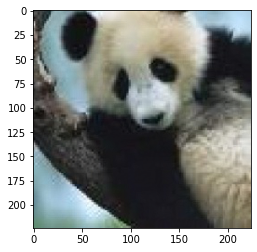

In [7]:
# Classify our image again
outputs = model.forward(img.unsqueeze(0))
outputs = torch.softmax(outputs, 1)
confidence, y_pred = torch.max(outputs.data, 1)
print('predicted label after FGSM: %s with confidence of %.2f'%(idx2label[y_pred], confidence.item()))
imshow(img, mean, std)